In [139]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

nov24_raw = pd.read_excel('./Voter Registration Data/county_nov24.xlsx')

all_data = {}

for file in glob.glob('./Voter Registration Data/*'):
    data = pd.read_excel(file)
    date = data.iloc[0,0][-4:]
    all_data[date] = data

In [140]:
def clean(raw_array):
    raw_array = raw_array.dropna()
    raw_array.columns = raw_array.loc[3]
    raw_array = raw_array.drop(3)
    raw_array.reset_index(drop=True, inplace=True)
    raw_array.columns.name = None

    int_cols = raw_array.columns[3:]
    str_cols = raw_array.columns[:3]

    for col in int_cols:
        raw_array[col] = raw_array[col].astype('int64')

    for col in str_cols:
        raw_array[col] = raw_array[col].str.strip()

    return raw_array

In [141]:
clean_data = {}

for date in all_data:
    clean_data[date] = clean(all_data[date])

In [142]:
# initalize the REGION column for all_totals
all_totals = clean_data['2019'].loc[clean_data['2019']['STATUS'].str.contains('Total'), ['REGION']]
all_totals['COUNTY'] = clean_data['2019'].loc[clean_data['2019']['STATUS'].str.contains('Total'), ['COUNTY']]

for date in clean_data:
    month_data = clean_data[date]
    all_totals[date] = month_data.loc[month_data['STATUS'].str.contains('Total'), ['TOTAL']]

all_totals.reset_index(drop=True, inplace=True)

In [143]:
all_perc = all_totals.transpose().tail(-2).pct_change() * 100

all_perc = all_perc.round(2)
all_perc.columns = all_totals['COUNTY'] 

quantiles_arr = []
outliers = []

dates = list(all_totals)[2:]

for date in dates:
    q1 = all_perc.transpose()[date].quantile(0.25).round(2)
    q2 = all_perc.transpose()[date].quantile(0.5).round(2)
    q3 = all_perc.transpose()[date].quantile(0.75).round(2)

    # print(all_perc.transpose()[date])
    # # print(all_perc.transpose()[date] < q1)
    # print(all_perc.transpose().loc[all_perc.transpose()[date] > 3], [date])
    # # if ((all_perc.transpose()[date] < (q1 - 1.5 * IQR)) or (all_perc.transpose()[date] > (q3 + 1.5 * IQR))):
    # #     print(all_perc.transpose()[0])

    quantiles_arr.append([q1, q2, q3])

quantiles = pd.DataFrame(quantiles_arr)
quantiles.columns = ['Q1', 'Q2', 'Q3']
quantiles.index = dates

all_perc = pd.concat([all_perc,quantiles], axis=1)

C:\Users\tgran\AppData\Local\Temp\ipykernel_9252\3562640954.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_perc = all_totals.transpose().tail(-2).pct_change() * 100


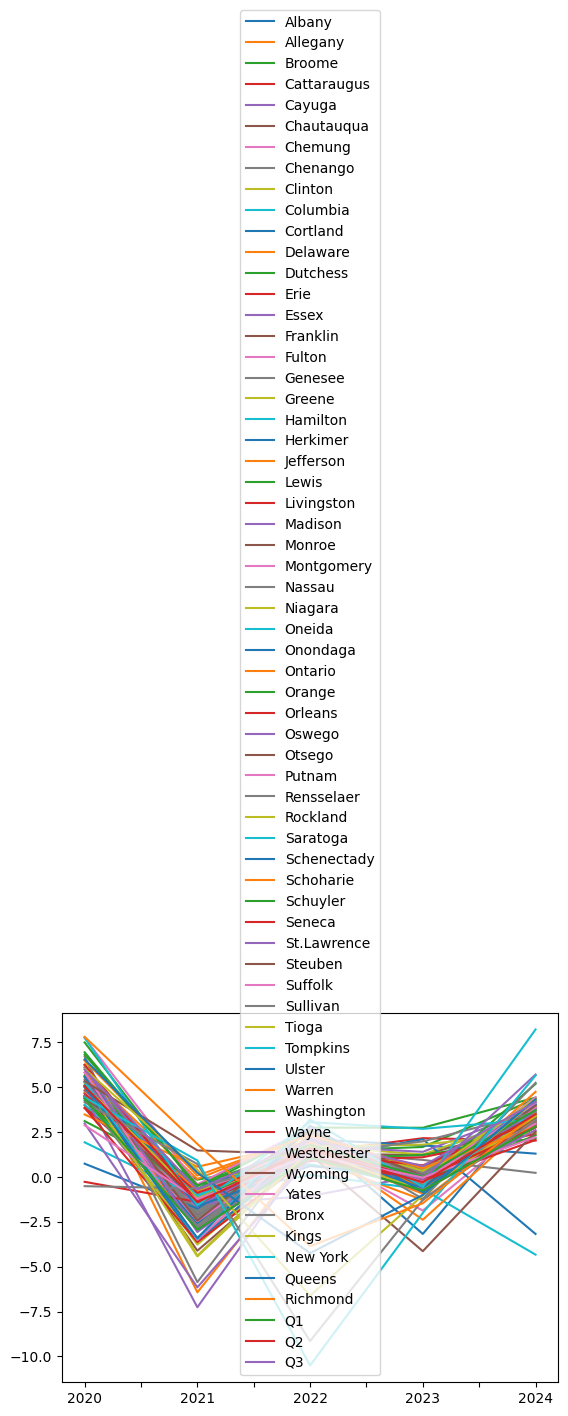

In [144]:
# quantiles.plot()
# plt.fill_between(quantiles.index, quantiles['Q1'], quantiles['Q3'], color='grey')
# plt.show()

all_perc.plot()
plt.fill_between(all_perc.index, all_perc['Q1'], all_perc['Q3'], color='grey')
plt.show()